In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
import warnings
warnings.filterwarnings("ignore")

import jax
import jax.random as jr

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)

# Example – Surrogate for stochastic heat equation with principal component analysis

In the previous example, we built a surrogate for the solution to the stochastic (steady-state) heat equation *at a single point in space*.
In this notebook, we will build a surrogate for *the entire temperature field*.

We will reuse the same probability measure on conductivity $c$, i.e., 

$$
c(x; \xi) = c_0(x) \exp\Big\{ g(x; \xi) \Big\}
$$ 

where $g$ is a Gaussian process.
As before, we implement it with the Karhunen-Loève expansion:

<!-- This allowed us to efficiently propagate uncertainty **from a random field** (the conductivity field) **to a random variable** (the temperature at the center of a rod).
In this example, instead of only building a surrogate for the solution at a single point, we will do so for the solution at **all points in space**.
This allows us to efficiently propagate uncertainty **from a random field** (the conductivity field) to **another random field** (the temperature field). -->
<!-- To do this, we put a Gaussian process prior on the conductivity field, took its Karhunen-Loève expansion, and trained  -->

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import equinox as eqx
from tinygp import GaussianProcess, kernels, transforms
from jaxtyping import Array, Float

class KarhunenLoeveExpansion(eqx.Module):
    """
    The Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Parameters
    ----------
    gp : tinygp.GaussianProcess
        The Gaussian process to expand.
    wq : Float[Array, "n_q"]
        The quadrature weights.
    alpha : float
        The percentage of the energy of the field that you want to keep.
    """
    gp: GaussianProcess
    lambd: Float[Array, "n_xi"]
    v: Float[Array, "n_xi n_q"]
    wq: Float[Array, "n_q"]
    
    def __init__(self, gp, wq, alpha=0.9):
        # Get the covariance (evaluated at the quadrature points).
        # If our gp is conditioned on some observations, then this will be the posterior covariance.
        Kq = gp.covariance

        # Get the eigenvalues/eigenvectors of the discretized covariance function
        B = jnp.einsum('ij,j->ij', Kq, wq)
        lam, v = jax.scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam = lam.at[lam <= 0.].set(0.)

        # Keep only the eigenvalues that explain alpha% of the energy
        energy = jnp.cumsum(lam) / jnp.sum(lam)
        i_end = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        
        self.gp = gp
        self.lambd = lam
        self.v = v
        self.wq = wq
    
    @property
    def energy(self):
        """The energy captured by the truncated expansion."""
        return jnp.sum(self.lambd)
    
    @property
    def num_xi(self):
        """The number of terms kept in the truncated expansion."""
        return self.lambd.shape[0]
    
    def eval_phi(self, x):
        """Evaluate the eigenfunctions at x."""
        Kc = self.gp.kernel(x, self.gp.X)  # Evaluate the cross-covariance between the query points (x) and the quadrature points (self.gp.X)
        phi = jnp.einsum("i,ji,j,rj->ri", 1/self.lambd, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """Evaluate the expansion at x and xi."""
        phi = self.eval_phi(x)
        return vmap(self.gp.mean_function)(x) + jnp.dot(phi, xi*self.lambd**0.5)

def build_kle(
    k, 
    nq=100, 
    alpha=0.9, 
    Xq=None, 
    wq=None, 
    Xobs=None, 
    yobs=None, 
    *, 
    input_dim
):
    """Build the Karhunen-Loève expansion of a Gaussian process.
    
    Parameters
    ----------
    k : tinygp.kernels.Kernel
        The kernel of the Gaussian process.
    nq : int
        The number of quadrature points.
    alpha : float
        The percentage of the energy of the field that you want the expansion to capture.
        This determines the number of terms in the expansion.
    Xq : jnp.ndarray
        The quadrature points.
    wq : jnp.ndarray
        The quadrature weights
    Xobs : jnp.ndarray
        The observed points.
    yobs : jnp.ndarray
        The observed values.
    input_dim : int
        The dimension of the input space.
    
    Returns
    -------
    kle : KarhunenLoeveExpansion
        The Karhunen-Loève expansion of the Gaussian process.
    """
    # Generate quadrature points
    if Xq is None:
        if input_dim == 1:
            Xq = jnp.linspace(0, 1, nq)[:, None]
            wq = jnp.ones((nq,))/nq
        elif input_dim == 2:
            nq = int(jnp.sqrt(nq))
            x = jnp.linspace(0, 1, nq)
            X1, X2 = jnp.meshgrid(x, x)
            Xq = jnp.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
            wq = jnp.ones((nq**2,))/nq**2
        else:
            raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
    
    # Build the Gaussian process
    if Xobs is not None:
        _, gp = GaussianProcess(k, Xobs, diag=1e-6).condition(y=yobs, X_test=Xq)
    else:
        gp = GaussianProcess(k, Xq, diag=1e-6)
    
    # Build the KLE
    return KarhunenLoeveExpansion(gp, wq, alpha)

In [3]:
k = 0.5*kernels.ExpSquared(scale=0.1)
kle = build_kle(k, nq=1000, alpha=0.95, input_dim=1)

def c(x, xi):
    """Compute the random thermal conductivity field for a given xi."""
    return jnp.exp(kle(x, xi))

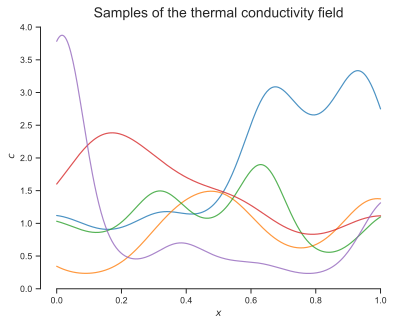

In [4]:
x = jnp.linspace(0, 1, 300)[:, None]
fig, ax = plt.subplots()
ax.set_title("Samples of the thermal conductivity field", fontsize=14)
for i in range(5):
    key, key_xi = jr.split(key)
    xi = jr.normal(key_xi, shape=(kle.num_xi,))
    f = c(x, xi)
    ax.plot(x, f, alpha=0.8)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$c$")
sns.despine(trim=True);

## Reduce dimensionality of the output with PCA

The goal is to propagate uncertainty from **one stochastic function** (the conductivity field) to **another stochastic function** (the temperature field).
This requires approximating the infinite-dimensional fields with something finite-dimensional.

We have already represented the input field with a finite number of Karhunen-Loève expansion coefficients (as done in the previous example).
In a similar vein, we will represent the output temperature field with a finite number of **principal component analysis (PCA) coefficients**.

Let's do it.
First we create a solver for the heat equation:

In [5]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    g           -    The random field the describes the conductivity.
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, c, nx=100, value_left=1., value_right=0.):
        self.c = c
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        c_val = self.c(x[:, None], xi)
        self.C.setValue(c_val)
        self.eq.solve(var=self.phi)
        return x, self.phi.faceValue()

In [6]:
solver = SteadyStateHeat1DSolver(c=c, nx=500)

Next, create some training (and testing) data:

In [7]:
xis = []
us = []
for i in range(100):
    key, key_xi = jr.split(key)
    xi = jr.normal(key_xi, shape=(kle.num_xi,))
    x, y = solver(xi)
    xis.append(xi)
    us.append(y)
xis = jnp.stack(xis, axis=0)
us = jnp.stack(us, axis=0)

from sklearn.model_selection import train_test_split
key, key_split = jr.split(key)
xi_train, xi_test, u_train, u_test = train_test_split(xis, us, test_size=0.1, random_state=int(jr.randint(key_split, shape=(), minval=0, maxval=1e6)))

And finally, do PCA on the training data:

In [8]:
class PrincipalComponentAnalysis(object):
    """A convenience class for performing principal component analysis (PCA)."""

    mean: Float[Array, "n_features"]
    U: Float[Array, "n_features n_components"]
    s: Float[Array, "n_components"]
    coefficients: Float[Array, "n_features n_components"]
    Vt: Float[Array, "n_components n_features"]

    def __init__(self, X, alpha=0.9):
        # Compute data mean
        x_bar = jnp.mean(X, axis=0)
        B = X - x_bar

        # Compute SVD
        U, s, Vt = jnp.linalg.svd(B, full_matrices=False)

        # Select the however many components explain alpha% of the energy
        energy = jnp.cumsum(s)/jnp.sum(s)
        n_components = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        U = U[:, :n_components]
        s = s[:n_components]
        Vt = Vt[:n_components]

        self.mean = x_bar
        self.U = U
        self.s = s
        self.coefficients = jnp.einsum('ij,j->ij', U, s)
        self.Vt = Vt
    
    @property
    def n_components(self):
        return self.Vt.shape[0]
    
    @property
    def principal_components(self):
        return self.Vt

    def project(self, X, n_components=None):
        """Project the data onto the principal components.
        
        Parameters
        ----------
        X : Float[Array, "n_samples n_features"]
            The data to project.
        n_components : int
            The number of principal components to use.
            If `None`, all components are used.
        
        Returns
        -------
        Float[Array, "n_samples n_components"]
        """
        if n_components is None:
            n_components = self.n_components
        return self.mean + jnp.einsum('ij,jk->ik', X, self.Vt[:n_components])

In [9]:
pca = PrincipalComponentAnalysis(u_train, alpha=0.95)

Both the input and output of our stochastic model can now be expressed as a weighted sum of fixed functions.
Let's visualize what these fixed functions are:

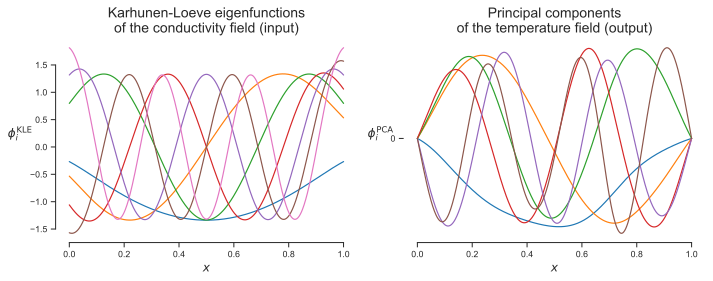

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

ax = axes[0]
ax.plot(x, kle.eval_phi(x[:, None]))
ax.set_title("Karhunen-Loeve eigenfunctions\nof the conductivity field (input)", fontsize=14)
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel(r'$\phi^\text{KLE}_i$', rotation=0, labelpad=10, fontsize=12)
sns.despine(trim=True)

ax = axes[1]
for i in range(pca.n_components):
    ax.plot(x, pca.principal_components[i, :], label=f"Component {i}")
ax.set_title("Principal components\nof the temperature field (output)", fontsize=14)
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel(r'$\phi^\text{PCA}_i$', rotation=0, labelpad=10, fontsize=12)
ax.set_xlabel(r"$x$")
sns.despine(trim=True)


To reiterate, every conductivity field can be approximately represented as the weighted sum 

$$
c(x) \approx \sum_{i=1}^{N_\text{KLE}} \xi_i \sqrt{\lambda_i} \phi^\text{KLE}_i(x)
$$

where the fixed functions $\{\phi^\text{KLE}_i | i=1, \dots, N_\text{KLE}\}$ are shown on the left in the figure above. 

Likewise, every temperature field can be approximately represented as the weighted sum 

$$
u(x) \approx \sum_{i=1}^{N_\text{PCA}} \eta_i \phi^\text{PCA}_i(x)
$$

where the fixed functions $\{\phi^\text{PCA}_i | i=1, \dots, N_\text{PCA}\}$ are shown on the right in the figure above.

## Surrogate for the stochastic model

We will now train a surrogate to approximate the mapping $\xi \mapsto \eta$ (i.e., the mapping from the input's KLE coefficients to the output's PCA coefficients).
This will enable fast uncertainty propagation over fields!

However, instead of directly creating one big multi-input-multi-output surrogate, we will train a separate Gaussian process surrogate for each PCA coefficient.
So, there will be a GP for the mapping $\xi \mapsto \eta_1$, another GP for $\xi \mapsto \eta_2$, and another for $\xi \mapsto \eta_3$, and so on.

Here we go:

In [11]:
from jax import lax, value_and_grad
import optax
from functools import partial

def build_gp(params, X):
    """Build a Gaussian process with RBF kernel.
    
    Parameters
    ----------
    params : dict
        Hyperparameters of the GP.
    X : ndarray
        Training data input locations.
    
    Returns
    -------
    GaussianProcess
        The GP.
    """
    amplitude = jnp.exp(params['log_amplitude'])
    lengthscale = jnp.exp(params['log_lengthscale'])
    k = amplitude*transforms.Linear(1/lengthscale, kernels.ExpSquared())
    return GaussianProcess(kernel=k, X=X, diag=1e-6)

def loss(params, X, y):
    """Negative marginal log likelihood of the GP."""
    gp = build_gp(params, X)
    return -gp.log_probability(y)

@eqx.filter_jit
def train_step_adam(carry, _, X, y, optim, batch_size):
    params, opt_state, key = carry
    key, subkey = jr.split(key)
    idx = jr.randint(subkey, (batch_size,), 0, X.shape[0])
    value, grads = value_and_grad(loss)(params, X[idx], y[idx])
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, key), value

def train_gp(init_params, X, y, num_iters, learning_rate, batch_size, key):
    """Optimize the hyperparameters (xi) of a GP using the Adam optimizer.
    
    Parameters
    ----------
    init_params : dict
        Initial values of the hyperparameters.
    X, y: ndarray
        Training data.
    num_iters : int
        Number of optimization steps.
    learning_rate : float
        Learning rate for the optimizer.
    
    Returns
    -------
    dict
        The optimized hyperparameters.
    ndarray
        The loss values at each iteration.
    """
    
    # Initialize the optimizer
    optim = optax.adam(learning_rate)

    # Initialize the optimizer state
    init_carry = (init_params, optim.init(init_params), key)

    # Do optimization
    train_step = partial(train_step_adam, X=X, y=y, optim=optim, batch_size=batch_size)
    carry, losses = lax.scan(train_step, init_carry, None, num_iters)

    return carry[0], losses  # (optimized params, loss values)

In [12]:
init_params = {
    'log_amplitude': 1.0, 
    'log_lengthscale': -jnp.ones(xis.shape[1]),  # Different lengthscale for each input dimension
}

pca_datasets = []
optimized_params = []
key, subkey = jr.split(key)
for i in range(pca.n_components):
    key, key_train = jr.split(key)
    X = xi_train
    y=pca.coefficients[:, i]
    p, _ = train_gp(
        init_params, 
        X=X, 
        y=y,
        num_iters=1000, 
        learning_rate=1e-2,
        batch_size=100,
        key=subkey
    )
    optimized_params.append(p)
    pca_datasets.append((X, y))

Great! We now have a trained GP for each PCA coefficient of the temperature field.
Let's group it all together in a single class for convenience:

In [13]:
class Surrogate(eqx.Module):
    """Surrogate for the stochastic model."""
    gps: list
    ys: list
    x: jnp.ndarray
    pca: PrincipalComponentAnalysis

    def __init__(self, params, datasets, x, pca):
        gps, ys = [], []
        for p, D in zip(params, datasets):
            X, y = D
            gps.append( build_gp(p, X) )
            ys.append(y)
        self.gps = gps
        self.ys = ys
        self.x = x
        self.pca = pca
    
    def __call__(self, xi):
        coefs = []
        for i in range(len(self.gps)):
            coefs.append( self.gps[i].predict(y=self.ys[i], X_test=xi) )
        coefs = jnp.stack(coefs, axis=1)
        return self.pca.project(coefs)

In [14]:
surrogate = Surrogate(optimized_params, pca_datasets, x, pca)

And let's test our surrogate's accuracy.
First, let's predict the full temperature field for each test case:

In [15]:
u_test_pred = surrogate(xi_test)

And let's compare them to the true fields with a parity plot:

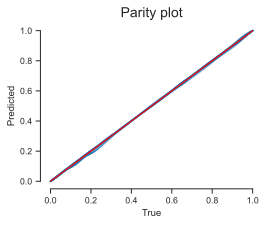

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title("Parity plot", fontsize=14)
ax.scatter(u_test.flatten(), u_test_pred.flatten(), 1, label="Predictions", alpha=0.3)
ax.plot([0, 1], [0, 1], 'r-', label="Ideal")
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
sns.despine(trim=True);

The fit looks good.

## Uncertainty propagation

We can now use the surrogate to do uncertainty quantification tasks for very cheap!

For example, let's compute some quantiles for the distribution of $u(x)$:

In [17]:
n_samples = 1000
key, key_xi = jr.split(key)
xi = jr.normal(key_xi, shape=(n_samples, kle.num_xi))
u = surrogate(xi)

u_mean = jnp.mean(u, axis=0)
u_025, u_975 = jnp.quantile(u, jnp.array([0.025, 0.975]), axis=0)

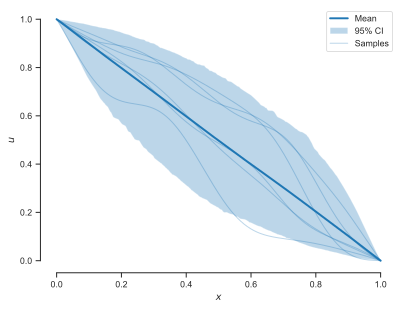

In [18]:
fig, ax = plt.subplots()
ax.plot(x, u_mean, label="Mean", lw=2, color='C0', zorder=100)
ax.fill_between(x.flatten(), u_025, u_975, alpha=0.3, label="95% CI", zorder=-100)
ax.plot(x, u[0], '-', lw=1, alpha=0.3, color='C0', label="Samples")
ax.plot(x, u[1:6].T, '-', lw=1, alpha=0.3, color='C0')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$")
ax.legend()
sns.despine(trim=True);

Take a moment to appreciate this.
With our newly built surrogate, we have propagated uncertainty ***through*** a partial differential equation ***from*** an infinite dimensional random field ***to another*** infinite dimensional random field.
***And*** evaluating the distribution of the entire output field only takes a fraction of a second!

Surrogates for stochastic models (like this one) can enable downstream tasks that were prohibitively expensive before.
For example, if we include some design variables in the input, we could perform design optimization under uncertainty.

## Questions

Play with the amount of training data, as well as number of KLE and PCA coefficients (controlled by the `alpha` parameters).